In [1]:
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

data = r'data/wilco_content_edgelist.csv'

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [3]:
df = pd.read_csv(data)

# fix the & so that scikit-network stops crashing
df['source'] = df['source'].str.replace('&', 'and')
df['target'] = df['target'].str.replace('&', 'and')

df.head()

,source,target
0,Jeff Tweedy,Wilco
1,Jeff Tweedy,Tweedy
2,Jeff Tweedy,Uncle Tupelo
3,Jeff Tweedy,Reprise Records
4,Jeff Tweedy,Warner Bros


# Create our original Graph

In [4]:
G_0 = nx.from_pandas_edgelist(df) # using G_0 instead of G for the Graph this time. G will be a dict of graphs.

In [5]:
nx.info(G_0)

'Graph with 914 nodes and 1297 edges'

# Identify connected components (for experimenting on group removal)

In [36]:
i = 0

components = {}

for component in nx.connected_components(G_0):
    
    components[i] = len(component)
    
    i += 1
    
component_df = pd.DataFrame(components, index=[0]).T
component_df.columns = ['node_count']

# the largest ones

component_df[component_df['node_count']>5]

,node_count
0,755
14,14
55,7
57,6


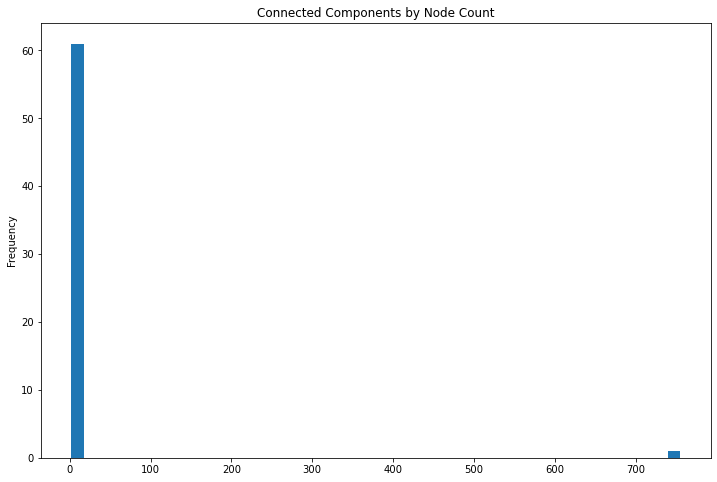

In [7]:
_= component_df['node_count'].plot.hist(bins=50, title='Connected Components by Node Count', figsize=(12,8))

In [8]:
degree_df = pd.DataFrame(G_0.degree)
degree_df.columns = ['node', 'degrees']
degree_df.head()

,node,degrees
0,Jeff Tweedy,40
1,Wilco,123
2,Tweedy,114
3,Uncle Tupelo,79
4,Reprise Records,11


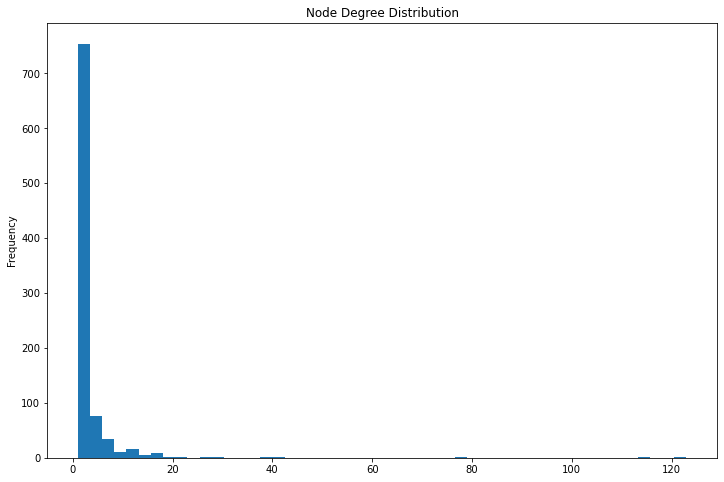

In [9]:
_= degree_df['degrees'].plot.hist(bins=50, title='Node Degree Distribution', figsize=(12,8))

In [10]:
# Many components with few nodes, few components with many nodes
# Many nodes with few edges, few nodes with many edges

# The latter is understood in network science. I wonder if the former is, as well, because I see that, too.

In [11]:
# today, we will cut whole components and see if we can find a way to detect what has been removed

In [12]:
components = list(nx.connected_components(G_0))

# Quick Component Exploration

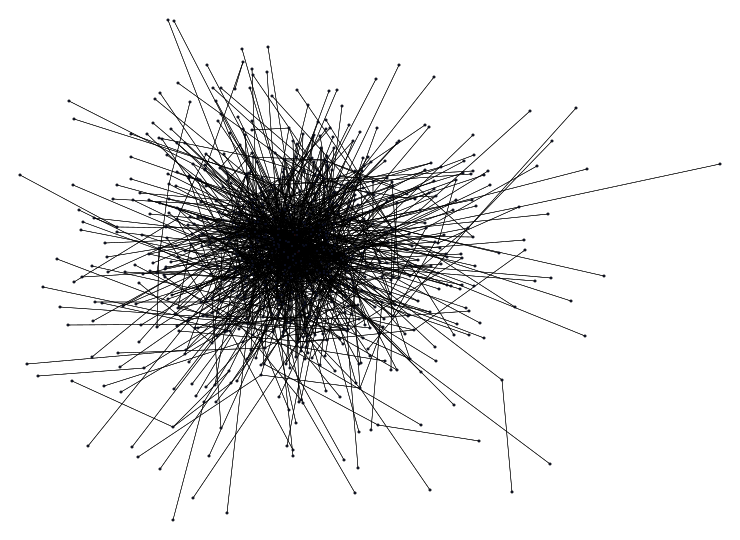

In [13]:
draw_graph(G_0.subgraph(components[0]))

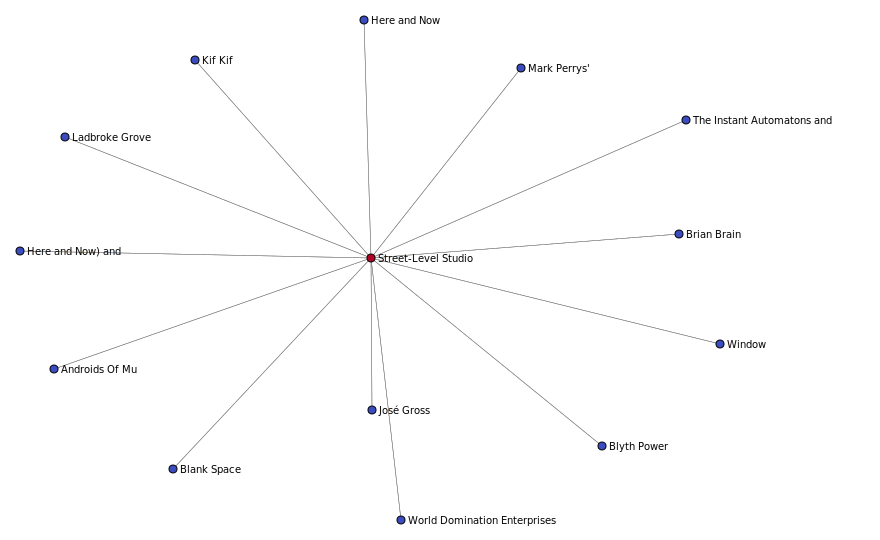

In [14]:
draw_graph(G_0.subgraph(components[14]), show_names=True, node_size=4)

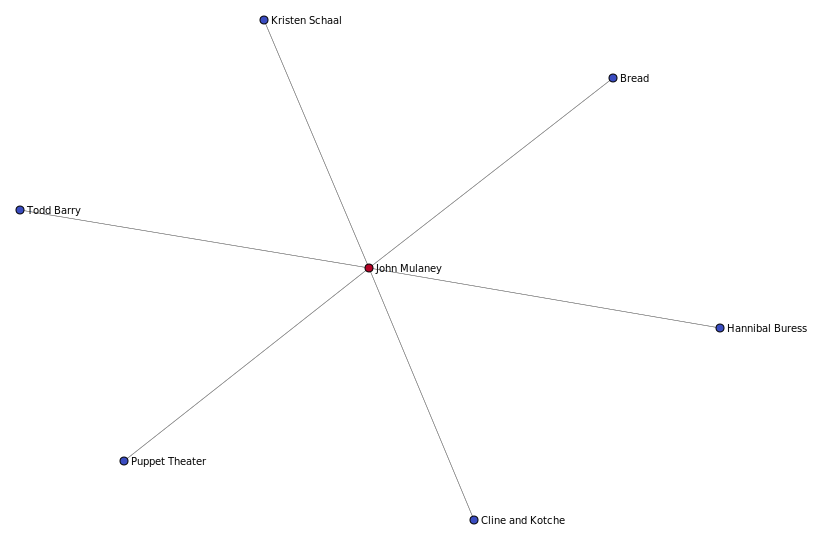

In [15]:
draw_graph(G_0.subgraph(components[55]), show_names=True, node_size=4)

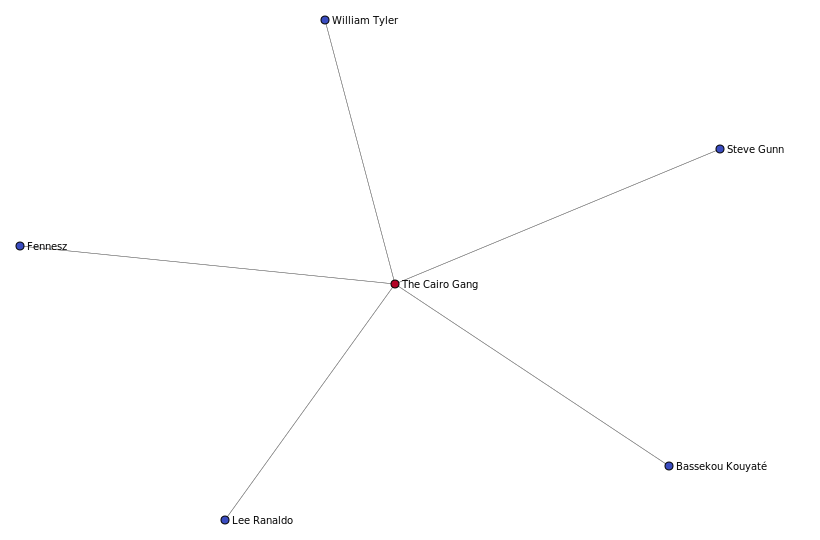

In [16]:
draw_graph(G_0.subgraph(components[57]), show_names=True, node_size=4)

# Create "Time Slices" of the Graph

We're going to simulate this. I don't have a temporal network, so I am going to simulate one by creating a few time slices, with an offset of just 0, 1, 2, 3, 4, etc.

In [17]:
component_df[component_df['node_count']>5]

,node_count
0,755
14,14
55,7
57,6


In [18]:
G = {}
G[0] = {}
G[0]['graph'] = G_0.copy()

In [19]:
drop_nodes = components[14]

G[1] = {}
G[1]['graph'] = G[0]['graph'].copy()
G[1]['graph'].remove_nodes_from(drop_nodes)

In [20]:
drop_nodes = components[55]

G[2] = {}
G[2]['graph'] = G[1]['graph'].copy()
G[2]['graph'].remove_nodes_from(drop_nodes)

In [21]:
drop_nodes = components[57]

G[3] = {}
G[3]['graph'] = G[2]['graph'].copy()
G[3]['graph'].remove_nodes_from(drop_nodes)

# Proof of Concept: Identifying Network Changes

In [22]:
current_edges = list(G[1]['graph'].edges)
previous_edges = list(G[0]['graph'].edges)

current_nodes = list(G[1]['graph'].nodes)
previous_nodes = list(G[0]['graph'].nodes)

# edge changes
dropped_edges = sorted([e for e in previous_edges if e not in current_edges])
added_edges = sorted([e for e in current_edges if e not in previous_edges])

# node changes
dropped_nodes = sorted([n for n in previous_nodes if n not in current_nodes])
added_nodes = sorted([n for n in current_nodes if n not in previous_nodes])

# dropped parts of Graph
G_dropped = nx.from_edgelist(dropped_edges)

# added parts of Graph
G_added = nx.from_edgelist(added_edges)

# changes to density (could use any "Whole Network Analysis" metrics, or centralities, etc; get creative)
density_change = nx.density(G[1]['graph']) - nx.density(G[0]['graph'])
degree_change = len(G[1]['graph'].degree) - len(G[0]['graph'].degree)
edge_change = len(G[1]['graph'].edges) - len(G[0]['graph'].edges)

# the point is that more and more change context can be added and then analyzed separately

In [23]:
dropped_edges

[('Street-Level Studio', 'Androids Of Mu'),
 ('Street-Level Studio', 'Blank Space'),
 ('Street-Level Studio', 'Blyth Power'),
 ('Street-Level Studio', 'Brian Brain'),
 ('Street-Level Studio', 'Here and Now'),
 ('Street-Level Studio', 'Here and Now) and'),
 ('Street-Level Studio', 'José Gross'),
 ('Street-Level Studio', 'Kif Kif'),
 ('Street-Level Studio', 'Ladbroke Grove'),
 ('Street-Level Studio', "Mark Perrys'"),
 ('Street-Level Studio', 'The Instant Automatons and'),
 ('Street-Level Studio', 'Window'),
 ('Street-Level Studio', 'World Domination Enterprises')]

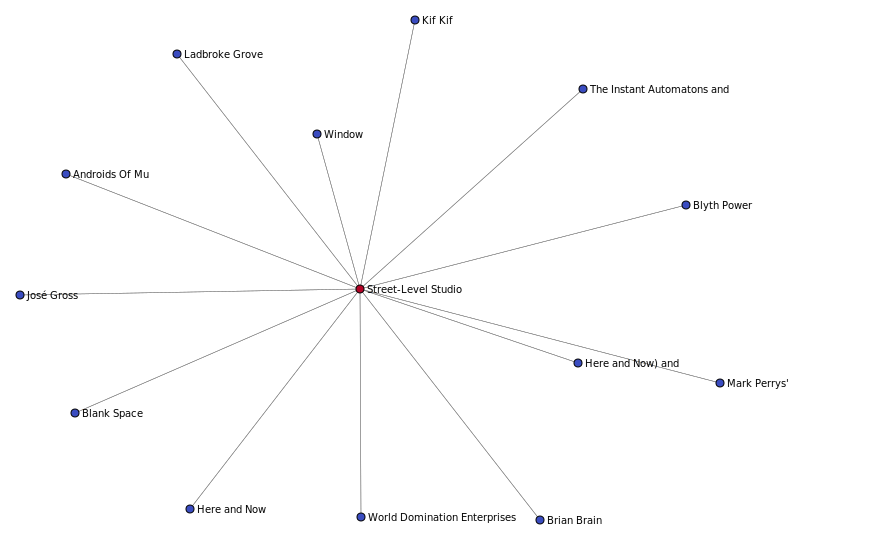

In [24]:
draw_graph(G_dropped, show_names=True, node_size=4)

# Proof of Concept to Function

Pass in the teporal graph G and this will loop through each index and identify changes. Much, much more context can be added. Be creative.

In [59]:
def enrich_temporal_graph(G):
    
    G = G.copy()
            
    for key in G.keys():
        
        cur_idx = key
                
        if key == 0:
            G[cur_idx]['density_change'] = nx.density(G[cur_idx]['graph'])
            G[cur_idx]['degree_change'] = len(G[cur_idx]['graph'].degree)
            G[cur_idx]['edge_change'] = len(G[cur_idx]['graph'].edges)
            continue
        
        prev_idx = key-1
            
        current_edges = list(G[cur_idx]['graph'].edges)
        previous_edges = list(G[prev_idx]['graph'].edges)

        current_nodes = list(G[cur_idx]['graph'].nodes)
        previous_nodes = list(G[prev_idx]['graph'].nodes)

        # edge changes
        dropped_edges = sorted([e for e in previous_edges if e not in current_edges])
        added_edges = sorted([e for e in current_edges if e not in previous_edges])
        G[cur_idx]['dropped_edges'] = dropped_edges
        G[cur_idx]['added_edges'] = added_edges

        # node changes
        dropped_nodes = sorted([n for n in previous_nodes if n not in current_nodes])
        added_nodes = sorted([n for n in current_nodes if n not in previous_nodes])
        G[cur_idx]['dropped_nodes'] = dropped_nodes
        G[cur_idx]['added_nodes'] = added_nodes

        # dropped parts of Graph
        G_dropped = nx.from_edgelist(dropped_edges)
        G[cur_idx]['graph_dropped'] = G_dropped

        # added parts of Graph
        G_added = nx.from_edgelist(added_edges)
        G[cur_idx]['graph_added'] = G_added

        # changes to density (could use any "Whole Network Analysis" metrics, or centralities, etc; get creative)
        density_change = nx.density(G[cur_idx]['graph']) - nx.density(G[prev_idx]['graph'])
        degree_change = len(G[cur_idx]['graph'].degree) - len(G[prev_idx]['graph'].degree)
        edge_change = len(G[cur_idx]['graph'].edges) - len(G[prev_idx]['graph'].edges)
        G[cur_idx]['density_change'] = density_change
        G[cur_idx]['degree_change'] = degree_change
        G[cur_idx]['edge_change'] = edge_change
        
    return G

# Enrich seperately from analysis

In [60]:
G = enrich_temporal_graph(G)

In [61]:
G[0]

{'graph': <networkx.classes.graph.Graph at 0x2c836bda3c8>,
 'density_change': 0.0031085152226171444,
 'degree_change': 914,
 'edge_change': 1297}

In [62]:
G[1]

{'graph': <networkx.classes.graph.Graph at 0x2c836bed708>,
 'dropped_edges': [('Street-Level Studio', 'Androids Of Mu'),
  ('Street-Level Studio', 'Blank Space'),
  ('Street-Level Studio', 'Blyth Power'),
  ('Street-Level Studio', 'Brian Brain'),
  ('Street-Level Studio', 'Here and Now'),
  ('Street-Level Studio', 'Here and Now) and'),
  ('Street-Level Studio', 'José Gross'),
  ('Street-Level Studio', 'Kif Kif'),
  ('Street-Level Studio', 'Ladbroke Grove'),
  ('Street-Level Studio', "Mark Perrys'"),
  ('Street-Level Studio', 'The Instant Automatons and'),
  ('Street-Level Studio', 'Window'),
  ('Street-Level Studio', 'World Domination Enterprises')],
 'added_edges': [],
 'dropped_nodes': ['Androids Of Mu',
  'Blank Space',
  'Blyth Power',
  'Brian Brain',
  'Here and Now',
  'Here and Now) and',
  'José Gross',
  'Kif Kif',
  'Ladbroke Grove',
  "Mark Perrys'",
  'Street-Level Studio',
  'The Instant Automatons and',
  'Window',
  'World Domination Enterprises'],
 'added_nodes': [],
 

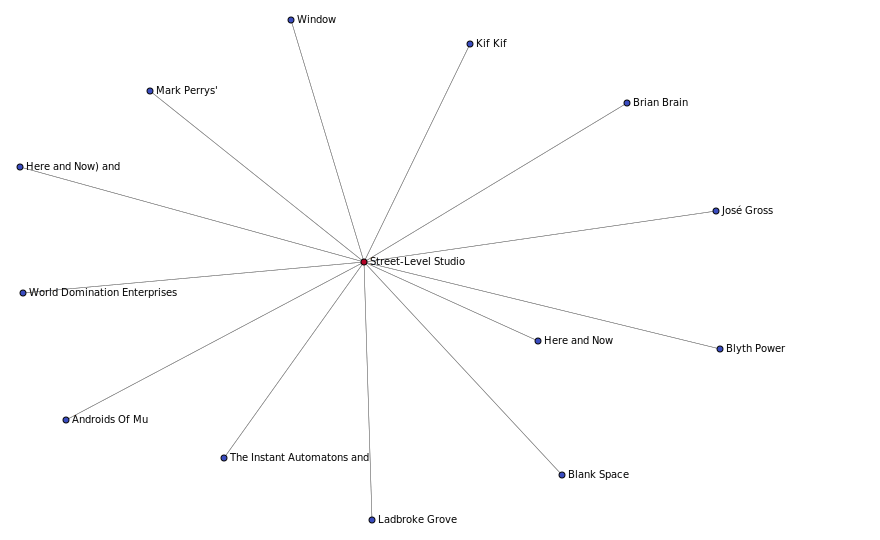

In [63]:
draw_graph(G[1]['graph_dropped'], node_size=3, show_names=True)

In [64]:
G[2]

{'graph': <networkx.classes.graph.Graph at 0x2c836be9588>,
 'dropped_edges': [('John Mulaney', 'Bread'),
  ('John Mulaney', 'Cline and Kotche'),
  ('John Mulaney', 'Hannibal Buress'),
  ('John Mulaney', 'Kristen Schaal'),
  ('John Mulaney', 'Puppet Theater'),
  ('John Mulaney', 'Todd Barry')],
 'added_edges': [],
 'dropped_nodes': ['Bread',
  'Cline and Kotche',
  'Hannibal Buress',
  'John Mulaney',
  'Kristen Schaal',
  'Puppet Theater',
  'Todd Barry'],
 'added_nodes': [],
 'graph_dropped': <networkx.classes.graph.Graph at 0x2c837247e48>,
 'graph_added': <networkx.classes.graph.Graph at 0x2c8370ea688>,
 'density_change': 3.49170215225565e-05,
 'degree_change': -7,
 'edge_change': -6}

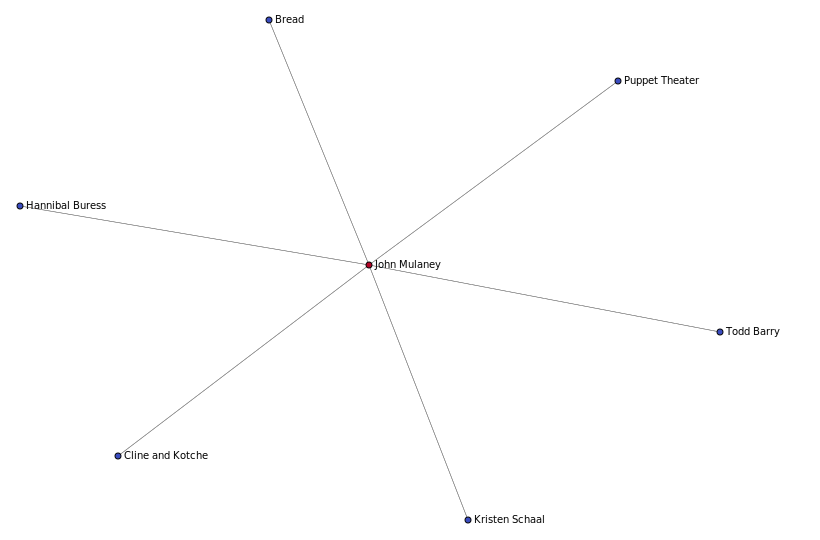

In [65]:
draw_graph(G[2]['graph_dropped'], node_size=3, show_names=True)

# Analysis done separately

In [66]:
change_df = pd.DataFrame(G).T

change_df.head()

,graph,density_change,degree_change,edge_change,dropped_edges,added_edges,dropped_nodes,added_nodes,graph_dropped,graph_added
0,"(Jeff Tweedy, Wilco, Tweedy, Uncle Tupelo, Rep...",0.003109,914,1297,NaN,NaN,NaN,NaN,NaN,NaN
1,"(Jeff Tweedy, Wilco, Tweedy, Uncle Tupelo, Rep...",0.000065,-14,-13,"[(Street-Level Studio, Androids Of Mu), (Stree...",[],"[Androids Of Mu, Blank Space, Blyth Power, Bri...",[],"(Street-Level Studio, Androids Of Mu, Blank Sp...",()
2,"(Jeff Tweedy, Wilco, Tweedy, Uncle Tupelo, Rep...",0.000035,-7,-6,"[(John Mulaney, Bread), (John Mulaney, Cline a...",[],"[Bread, Cline and Kotche, Hannibal Buress, Joh...",[],"(John Mulaney, Bread, Cline and Kotche, Hannib...",()
3,"(Jeff Tweedy, Wilco, Tweedy, Uncle Tupelo, Rep...",0.000031,-6,-5,"[(The Cairo Gang, Bassekou Kouyaté), (The Cair...",[],"[Bassekou Kouyaté, Fennesz, Lee Ranaldo, Steve...",[],"(The Cairo Gang, Bassekou Kouyaté, Fennesz, Le...",()


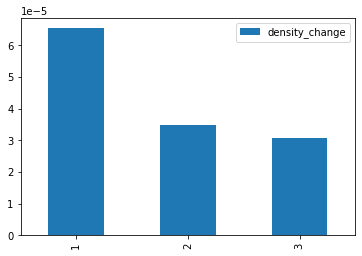

In [70]:
_= change_df['density_change'][1:].plot.bar(legend=True)

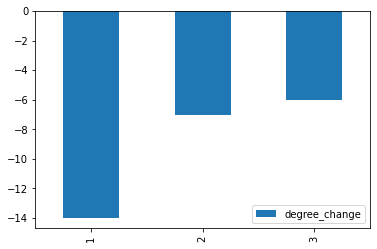

In [71]:
_= change_df['degree_change'][1:].plot.bar(legend=True)

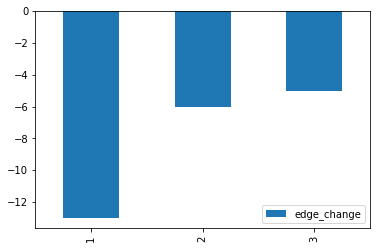

In [74]:
_= change_df['edge_change'][1:].plot.bar(legend=True)